<a href="https://colab.research.google.com/github/alcideschaux/CD8_FOXP3_PENIS/blob/main/CD8_FOXP3_PENIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import scipy
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

print(pd.__version__)
print(np.__version__)
print(scipy.__version__)

2.2.2
2.0.2
1.15.3


In [2]:
import sys
print(sys.version)

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


In [3]:
# Loading and checking dataset
DF = pd.read_csv('PFCK_PRY_DF.csv')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   x                      528 non-null    int64  
 1   y                      528 non-null    int64  
 2   sp                     528 non-null    object 
 3   tma                    528 non-null    int64  
 4   subtype                528 non-null    object 
 5   subtype_who            528 non-null    object 
 6   grade                  504 non-null    object 
 7   pdl1_tumor             504 non-null    float64
 8   pdl1_tumor_location    331 non-null    object 
 9   pdl1_tumor_h           504 non-null    float64
 10  pdl1_lymph             497 non-null    float64
 11  host_response          504 non-null    object 
 12  foxp3_lymph_tumor      80 non-null     float64
 13  foxp3_lymph_stroma     80 non-null     float64
 14  foxp3_lymph_intensity  80 non-null     object 
 15  foxp3_

In [4]:
# Select rows with TMA==852 (the TMA that was used for staining)
DF = DF[DF['tma'] == 852]
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 0 to 389
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   x                      144 non-null    int64  
 1   y                      144 non-null    int64  
 2   sp                     144 non-null    object 
 3   tma                    144 non-null    int64  
 4   subtype                144 non-null    object 
 5   subtype_who            144 non-null    object 
 6   grade                  140 non-null    object 
 7   pdl1_tumor             140 non-null    float64
 8   pdl1_tumor_location    110 non-null    object 
 9   pdl1_tumor_h           140 non-null    float64
 10  pdl1_lymph             136 non-null    float64
 11  host_response          140 non-null    object 
 12  foxp3_lymph_tumor      80 non-null     float64
 13  foxp3_lymph_stroma     80 non-null     float64
 14  foxp3_lymph_intensity  80 non-null     object 
 15  foxp3_tumor

In [5]:
# Number of unique patients in TMA 852
DF['sp'].nunique()

35

In [6]:
# Select spots with FOXP3/CD8 data, by excluding NAs
DF.dropna(subset=['foxp3_lymph_tumor', 'foxp3_lymph_stroma', 'cd8_tumor', 'cd8_stroma'], inplace=True)
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 0 to 353
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   x                      79 non-null     int64  
 1   y                      79 non-null     int64  
 2   sp                     79 non-null     object 
 3   tma                    79 non-null     int64  
 4   subtype                79 non-null     object 
 5   subtype_who            79 non-null     object 
 6   grade                  79 non-null     object 
 7   pdl1_tumor             78 non-null     float64
 8   pdl1_tumor_location    60 non-null     object 
 9   pdl1_tumor_h           78 non-null     float64
 10  pdl1_lymph             77 non-null     float64
 11  host_response          78 non-null     object 
 12  foxp3_lymph_tumor      79 non-null     float64
 13  foxp3_lymph_stroma     79 non-null     float64
 14  foxp3_lymph_intensity  79 non-null     object 
 15  foxp3_tumor 

<ipython-input-6-eb0e4e795c16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF.dropna(subset=['foxp3_lymph_tumor', 'foxp3_lymph_stroma', 'cd8_tumor', 'cd8_stroma'], inplace=True)


In [7]:
# Number of patients included in the final dataset
DF['sp'].nunique()

23

In [8]:
# Select DF columns of interest
selected_columns = [
    'subtype',
    'subtype_who',
    'grade',
    'foxp3_lymph_tumor',
    'foxp3_lymph_stroma',
    'cd8_tumor',
    'cd8_stroma',
    'cd8foxp3_tumor',
    'cd8foxp3_stroma'
    ]
DF = DF[selected_columns]
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 0 to 353
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   subtype             79 non-null     object 
 1   subtype_who         79 non-null     object 
 2   grade               79 non-null     object 
 3   foxp3_lymph_tumor   79 non-null     float64
 4   foxp3_lymph_stroma  79 non-null     float64
 5   cd8_tumor           79 non-null     float64
 6   cd8_stroma          79 non-null     float64
 7   cd8foxp3_tumor      79 non-null     object 
 8   cd8foxp3_stroma     79 non-null     object 
dtypes: float64(4), object(5)
memory usage: 6.2+ KB


In [9]:
# A function to calculate Cramer's v
def cramers_v(x, y):
  """
    Calculates Cramer's V statistic for two categorical variables.

    Args:
      x: A pandas Series representing the first categorical variable.
      y: A pandas Series representing the second categorical variable.

    Returns:
      The Cramer's V statistic.
    """
  confusion_matrix = pd.crosstab(x, y)
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  r, k = confusion_matrix.shape

  # Handle cases where one dimension is 1 (results in NaN)
  if min(r, k) == 1:
    return 0.0

  phi2 = chi2 / n

  v = np.sqrt(phi2 / min(r - 1, k - 1))

  return v

# Descriptive Statistics

## Pathologic Features

In [10]:
# Histological Subtype (ALL)
DF['subtype'].value_counts()

,count
subtype,
Usual,38
Warty-Basaloid,30
Basaloid,8
Warty,3


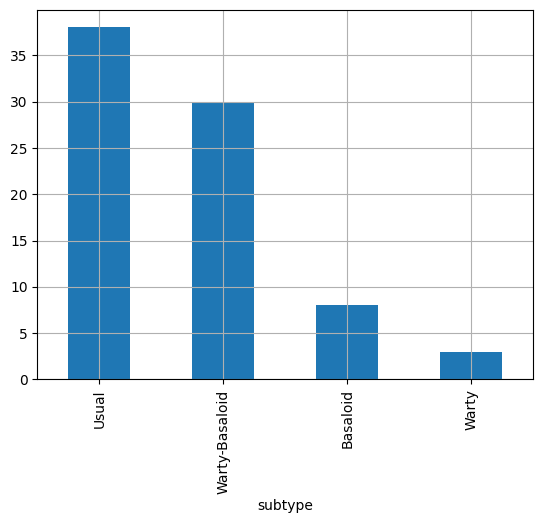

In [11]:
DF['subtype'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

In [12]:
# Histologica Subtype (WHO)
DF['subtype_who'].value_counts()

,count
subtype_who,
HPV-associated,41
HPV-independent,38


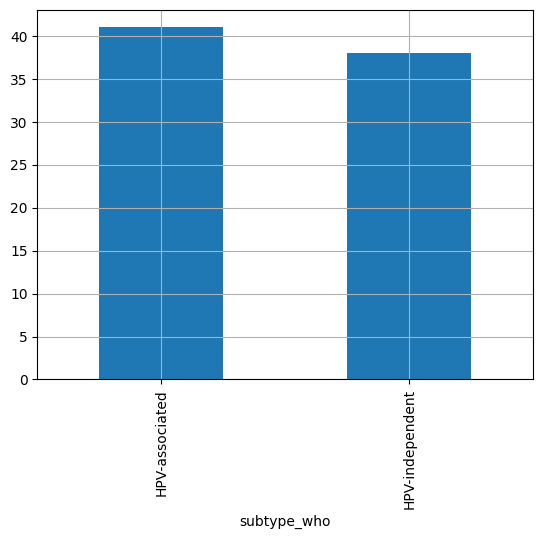

In [13]:
DF['subtype_who'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

In [14]:
# Histological Grade
DF['grade'].value_counts()

,count
grade,
Grade 3,43
Grade 2,29
Grade 1,7


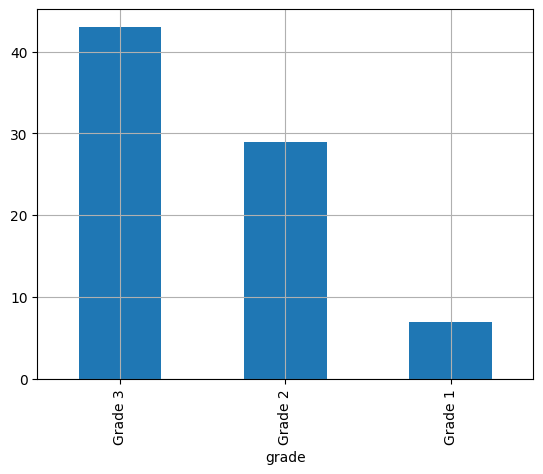

In [15]:
DF['grade'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

## FOXP3 Expression (counts/HPF)

In [16]:
# FOXP3 in Intratumoral Lymphocytes
DF['foxp3_lymph_tumor'].describe()

,foxp3_lymph_tumor
count,79.000000
mean,10.430380
std,14.205167
min,0.000000
25%,1.000000
50%,4.000000
75%,12.500000
max,56.000000


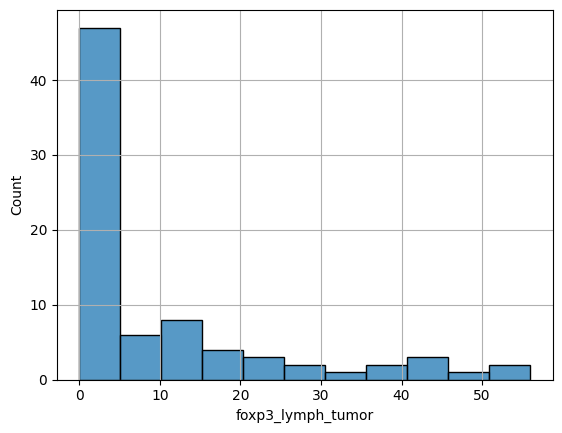

In [17]:
sns.histplot(data=DF, x='foxp3_lymph_tumor')
plt.grid()
plt.show()

In [18]:
#FOXP3 in Peritumoral Lymphocytes
DF['foxp3_lymph_stroma'].describe()

,foxp3_lymph_stroma
count,79.000000
mean,46.911392
std,38.458499
min,0.000000
25%,15.000000
50%,38.000000
75%,71.500000
max,145.000000


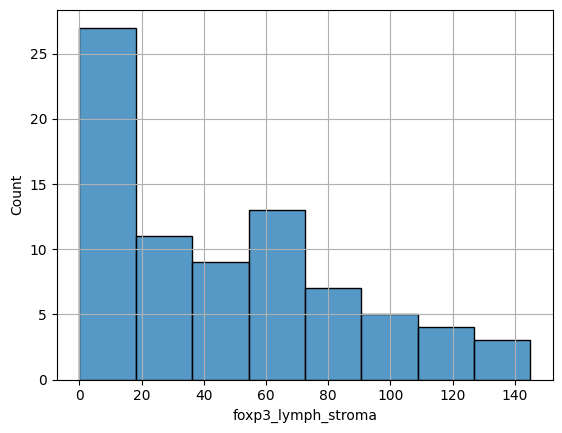

In [19]:
sns.histplot(data=DF, x='foxp3_lymph_stroma')
plt.grid()
plt.show()

## CD8 Expression (counts/HPF)

In [20]:
# CD8 in Intratumoral Lymphocytes
DF['cd8_tumor'].describe()

,cd8_tumor
count,79.000000
mean,10.860759
std,13.671732
min,0.000000
25%,0.000000
50%,5.000000
75%,15.000000
max,62.000000


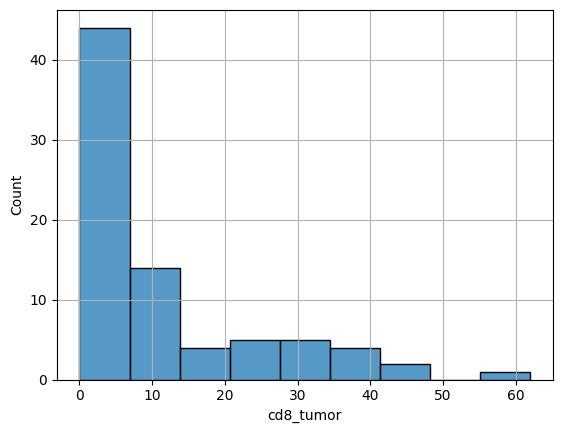

In [21]:
sns.histplot(data=DF, x='cd8_tumor')
plt.grid()
plt.show()

In [22]:
# CD8 in Peritumoral Lymphocytes
DF['cd8_stroma'].describe()

,cd8_stroma
count,79.000000
mean,30.303797
std,26.702230
min,0.000000
25%,7.500000
50%,22.000000
75%,49.000000
max,96.000000


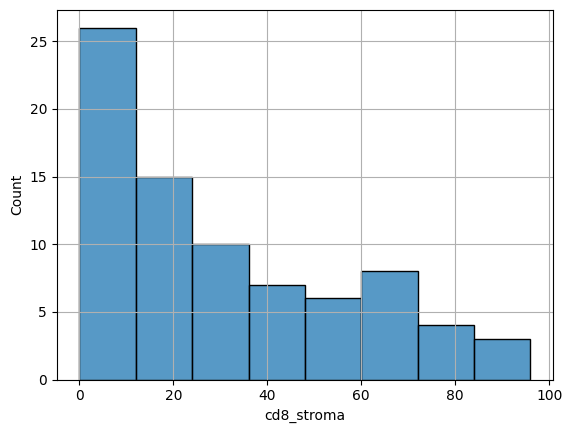

In [23]:
sns.histplot(data=DF, x='cd8_stroma')
plt.grid()
plt.show()

## CD8/FOXP3 Ratios

In [24]:
# CD8/FOXP3 in Intratumoral Lymphocytes
DF['cd8foxp3_tumor'].value_counts()

,count
cd8foxp3_tumor,
CD8 <= FOXP3,47
CD8 > FOXP3,32


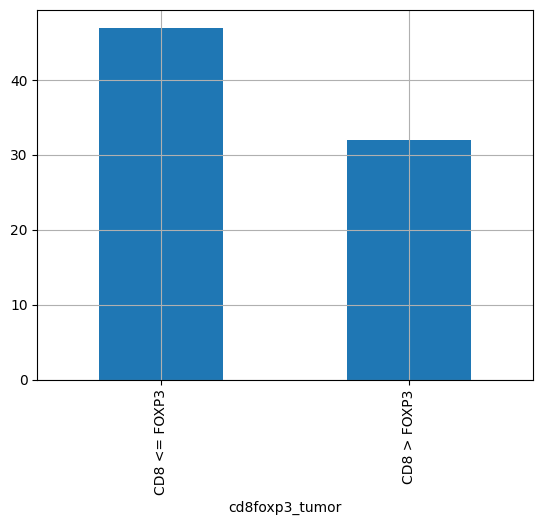

In [25]:
DF['cd8foxp3_tumor'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

In [26]:
# CD8/FOXP3 in Peritumoral Lymphocyes
DF['cd8foxp3_stroma'].value_counts()

,count
cd8foxp3_stroma,
CD8 <= FOXP3,61
CD8 > FOXP3,18


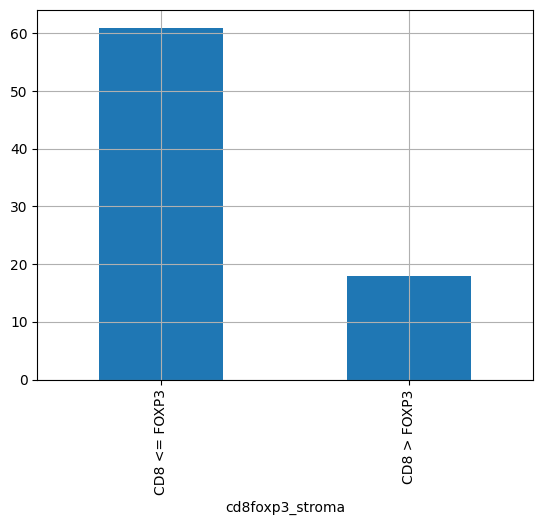

In [27]:
DF['cd8foxp3_stroma'].value_counts().plot(kind='bar')
plt.grid()
plt.show()

# Association between Ratios and Features

## Ratios by Subtypes

In [28]:
# CD8/FOXP3 Intratumoral Lymphocytes by Subtype
pd.crosstab(DF['subtype'], DF['cd8foxp3_tumor'])

cd8foxp3_tumor,CD8 <= FOXP3,CD8 > FOXP3
subtype,,
Basaloid,5,3
Usual,24,14
Warty,3,0
Warty-Basaloid,15,15


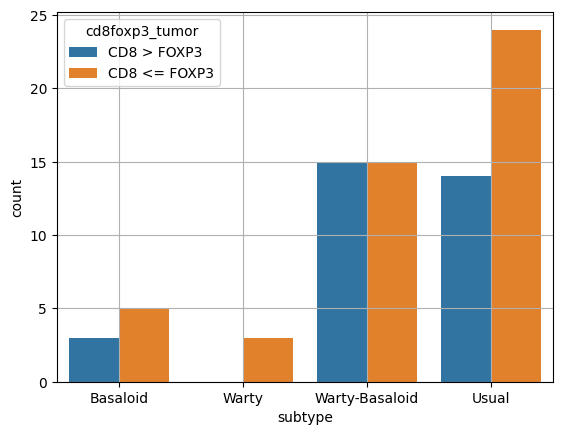

In [29]:
sns.countplot(data=DF, x='subtype', hue='cd8foxp3_tumor')
plt.grid()
plt.show()

In [30]:
chi2_contingency(pd.crosstab(DF['subtype'], DF['cd8foxp3_tumor']))

Chi2ContingencyResult(statistic=np.float64(3.406280620100784), pvalue=np.float64(0.3331221666428966), dof=3, expected_freq=array([[ 4.75949367,  3.24050633],
       [22.60759494, 15.39240506],
       [ 1.78481013,  1.21518987],
       [17.84810127, 12.15189873]]))

In [31]:
cramers_v(DF['subtype'], DF['cd8foxp3_tumor'])

np.float64(0.20764748061030597)

In [32]:
# CD8/FOXP3 in Intratumoral Lymphocytes by WHO SUbtype
pd.crosstab(DF['subtype_who'], DF['cd8foxp3_tumor'])

cd8foxp3_tumor,CD8 <= FOXP3,CD8 > FOXP3
subtype_who,,
HPV-associated,23,18
HPV-independent,24,14


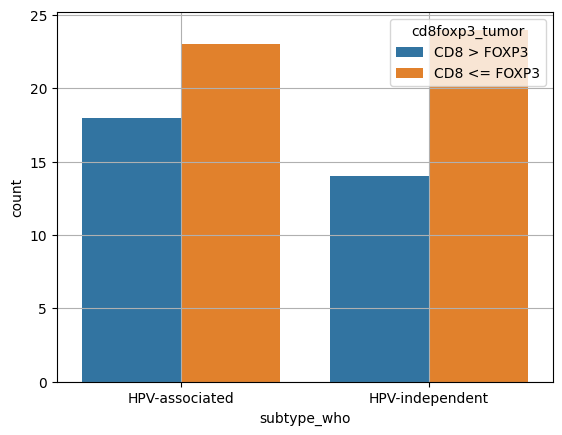

In [33]:
sns.countplot(data=DF, x='subtype_who', hue='cd8foxp3_tumor')
plt.grid()
plt.show()

In [34]:
chi2_contingency(pd.crosstab(DF['subtype_who'], DF['cd8foxp3_tumor']))

Chi2ContingencyResult(statistic=np.float64(0.16756759467265736), pvalue=np.float64(0.6822826729041804), dof=1, expected_freq=array([[24.39240506, 16.60759494],
       [22.60759494, 15.39240506]]))

In [35]:
cramers_v(DF['subtype_who'], DF['cd8foxp3_tumor'])

np.float64(0.04605549688500577)

In [36]:
# CD8/FOXP3 in Peritumoral Lymphocytes by Subtypes
pd.crosstab(DF['subtype'], DF['cd8foxp3_stroma'])

cd8foxp3_stroma,CD8 <= FOXP3,CD8 > FOXP3
subtype,,
Basaloid,7,1
Usual,33,5
Warty,2,1
Warty-Basaloid,19,11


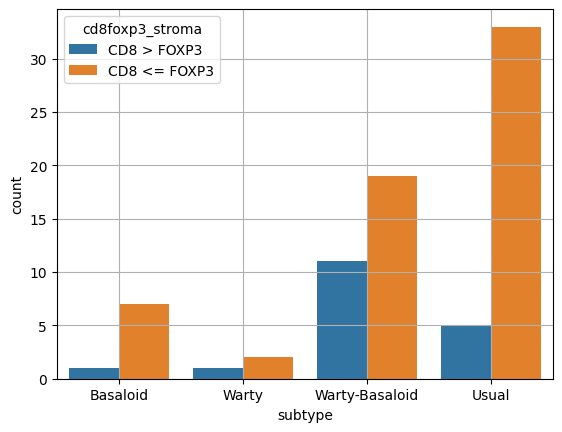

In [37]:
sns.countplot(data=DF, x='subtype', hue='cd8foxp3_stroma')
plt.grid()
plt.show()

In [38]:
chi2_contingency(pd.crosstab(DF['subtype'], DF['cd8foxp3_stroma']))

Chi2ContingencyResult(statistic=np.float64(5.958481529415524), pvalue=np.float64(0.11364775396063814), dof=3, expected_freq=array([[ 6.17721519,  1.82278481],
       [29.34177215,  8.65822785],
       [ 2.3164557 ,  0.6835443 ],
       [23.16455696,  6.83544304]]))

In [39]:
cramers_v(DF['subtype'], DF['cd8foxp3_stroma'])

np.float64(0.2746339688167591)

In [40]:
# CD8/FOXP3 in Peritumoral Lymphocytes by Subtypes (WHO)
pd.crosstab(DF['subtype_who'], DF['cd8foxp3_stroma'])

cd8foxp3_stroma,CD8 <= FOXP3,CD8 > FOXP3
subtype_who,,
HPV-associated,28,13
HPV-independent,33,5


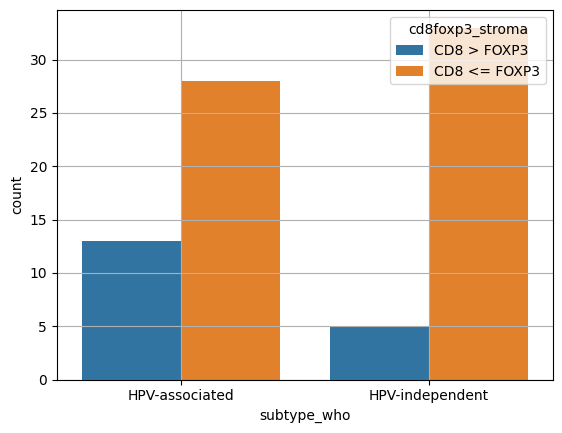

In [41]:
sns.countplot(data=DF, x='subtype_who', hue='cd8foxp3_stroma')
plt.grid()
plt.show()

In [42]:
chi2_contingency(pd.crosstab(DF['subtype_who'], DF['cd8foxp3_stroma']))

Chi2ContingencyResult(statistic=np.float64(2.874738847151198), pvalue=np.float64(0.08997957076617072), dof=1, expected_freq=array([[31.65822785,  9.34177215],
       [29.34177215,  8.65822785]]))

In [43]:
cramers_v(DF['subtype_who'], DF['cd8foxp3_stroma'])

np.float64(0.19075927062931392)

## Ratios by Grades

In [44]:
# CD8/FOXp3 in Intratumoral Lymphocytes by Grades
pd.crosstab(DF['grade'], DF['cd8foxp3_tumor'])

cd8foxp3_tumor,CD8 <= FOXP3,CD8 > FOXP3
grade,,
Grade 1,3,4
Grade 2,19,10
Grade 3,25,18


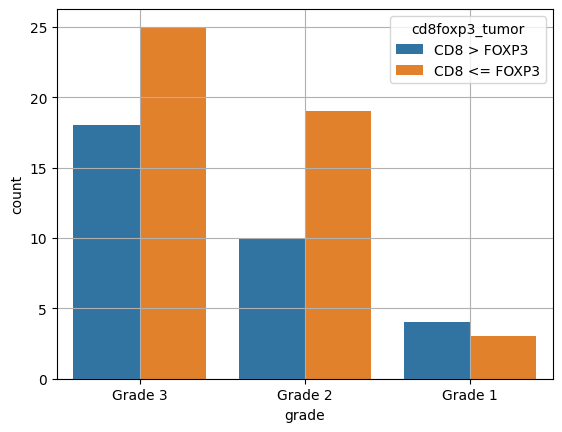

In [45]:
sns.countplot(data=DF, x='grade', hue='cd8foxp3_tumor')
plt.grid()
plt.show()

In [46]:
chi2_contingency(pd.crosstab(DF['grade'], DF['cd8foxp3_tumor']))

Chi2ContingencyResult(statistic=np.float64(1.2732990788835452), pvalue=np.float64(0.5290620594037636), dof=2, expected_freq=array([[ 4.16455696,  2.83544304],
       [17.25316456, 11.74683544],
       [25.58227848, 17.41772152]]))

In [47]:
cramers_v(DF['grade'], DF['cd8foxp3_tumor'])

np.float64(0.12695554284585367)

In [48]:
# CD8/FOXP3 in Peritumoral Lymphocytes by Grades
pd.crosstab(DF['grade'], DF['cd8foxp3_stroma'])

cd8foxp3_stroma,CD8 <= FOXP3,CD8 > FOXP3
grade,,
Grade 1,5,2
Grade 2,24,5
Grade 3,32,11


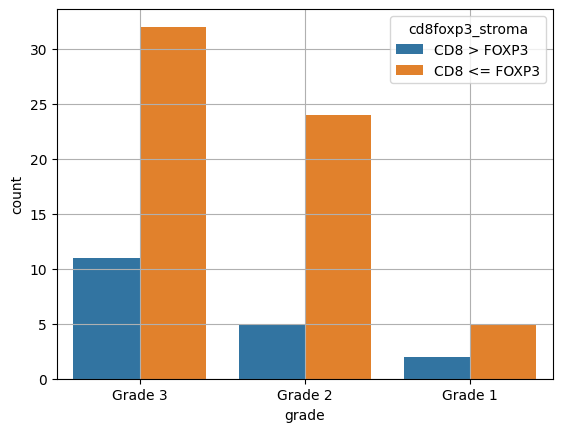

In [49]:
sns.countplot(data=DF, x='grade', hue='cd8foxp3_stroma')
plt.grid()
plt.show()

In [50]:
chi2_contingency(pd.crosstab(DF['grade'], DF['cd8foxp3_stroma']))

Chi2ContingencyResult(statistic=np.float64(0.8309124307914846), pvalue=np.float64(0.66003909201118), dof=2, expected_freq=array([[ 5.40506329,  1.59493671],
       [22.39240506,  6.60759494],
       [33.20253165,  9.79746835]]))

In [51]:
cramers_v(DF['grade'], DF['cd8foxp3_stroma'])

np.float64(0.10255671051071347)